### Load module

In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import copy
plt.rc('text', usetex=True)

### big picture

Attributes that we want to include
+ acc:
    - TIME;
    - WEEKDAY; (category)
    - RDSURF; (category)
    - LIGHT; (category)
    - WEATHER; (category)
+ curv:
    - deg_curv;
+ grad:
    - pct_grad;
+ road:
    - AADT;
    - trkpcts;
    - mvmt;
    - RURURB; (category)
    - MED_TYPE, MEDWID;
    - LSHL_TYP, LSHL_TY2, LSHLDWID, LSHL_WD2; (2 represents decreasing direction)
    - RSHL_TYP, RSHL_TY2, RSHLDWID, RSHL_WD2;
    - SURF_TYP, SURF_TY2; (The composition of the driving surfacein two directions)
    - lanewid, rdwy_wid; (on average, need filter > 0)
    - FUNC_CLS; (? this might be an summary variable that includes info of all previous variables)(category)
+ occ:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;None;
+ peds:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;None;
+ veh:
    - DRV_SEX; (need to summarize)
    - DRV_AGE; (need to summarize)
    - vehtype; (>4 is big ones?)
    - surf_typ; (Roadway surface type at the crash location? redundant info? No they do not agree)
    - drv_actn; (difficult)
    - intox; (need to summarize)

### functions and pre-test

#### read function - everybody needs

In [ ]:
def detect_files(directory, keyword):
    """
    detect files in specified directory with specified keyword

    input
    -----
    directory : string
        dir to search

    keyword : string
        keyword to look for

    output
    -----
    sorted list of file names

    test
    -----
        (1) if output has larger than length;
    """

    file_list = []
    for file in os.listdir(directory):
        if not (keyword is None):
            if keyword in file:
                file_list.append(file)
        else:
            file_list.append(file)
    
    return sorted(file_list)

def read_files(directory, keyword):
    """
    read files with specified keyword

    input
    -----
    directory : string
        directory to read files from

    keyword : string
        keyword to search for

    output
    -----
    output_dic : dic
        dictionary of datasets

    test
    -----
        (1) output_dic should have length 5, for 2013 - 2017;
        (2) keyword should not be empty;
    """
    output_dic = {}
    file_list = detect_files(directory, keyword)
    for yr in range(2013, 2018):
        output_dic[yr] = pd.read_csv(os.path.join(directory, file_list[yr-2013]))
    return output_dic

#### test on veh aggregation
This function will be used in s3_merge.py

In [ ]:
def veh_agg(df, crash_year):
    """
    aggregate vehicle info

    input
    -----
    df : pandas dataframe
        df to be summarized

    output
    -----
    df: pandas dataframe
        aggregated df

    """
    def sex(series):
        for ele in series.tolist():
            if ele > 1:
                return True
        return False

    def young(series):
        for ele in series.tolist():
            if ele < 25:
                return True
        return False

    def old(series):
        for ele in series.tolist():
            if ele > 65:
                return True
        return False

    def drink(series):
        for ele in series.tolist():
            if ele == 1.0 or ele == 5.0:
                return True
        return False

    def truck(series):
        for ele in series.tolist():
            if ele > 4:
                return True
        return False
    
    def old_car(series):
        for ele in series.tolist():
            model_year = 1900
            if ele < 10:
                model_year += (100 + ele)
            elif ele < 20:
                model_year += (100 + ele)
            else:
                model_year += (ele)
            
            if crash_year - model_year >= 15:
                return True
        return False
    
    df = df.groupby(['CASENO']).agg({'DRV_SEX': [sex],
                            'DRV_AGE': [young, old],
                            'vehtype': [truck],
                            'vehyr': [old_car],
                            # 'surf_typ': ,
                            # 'drv_actn': ,
                            'intox': [drink]
                           })
    df.columns = df.columns.get_level_values(1)
    df = df.reset_index()
    return df

In [ ]:
veh_agg(veh[2017], 2017)

### analysis

#### read, extract, combine

In [ ]:
crash = read_files("./merged", '20')

In [ ]:
columns = [
    'REPORT', 'ACCTYPE',
    'TIME', 'WEEKDAY', 'RDSURF', 'LIGHT', 'weather',
    'deg_curv',
    'pct_grad',
    'AADT', 'trkpcts', 'mvmt', 'RURURB', 'MED_TYPE', 'MEDWID', 
    'LSHL_TYP', 'LSHL_TY2', 'LSHLDWID', 'LSHL_WD2', 'RSHL_TYP', 'RSHL_TY2', 'RSHLDWID', 'RSHL_WD2',
    'SURF_TYP', 'SURF_TY2', 'lanewid', 'rdwy_wid', 'FUNC_CLS',
    'sex', 'young', 'old', 'drink', 'truck', 'old_car'
]

for year in crash:
    df = crash[year]
    crash[year] = df[columns]

In [ ]:
crash[2017]

In [ ]:
pd.unique(crash[2017]['weather'])

#### focus on type 33
***Strikes Appurtenance***<br>
Need to drop NA values. 
+ Notice, **AADT**, **trkpcts**, **mvmt** have NA values. This is strongly undesirable;
+ We drop rows with NA in those rows and thus retrieve 4,658 rows from 4,694 rows. That's not much loss;

In [ ]:
df = crash[2017]
df = df[df.ACCTYPE == 33]
# df = df.dropna()
df

In [ ]:
df.isna().any()

In [ ]:
df.dropna(subset=['AADT', 'trkpcts', 'mvmt'])

#### append and obtain the final large dataset

In [ ]:
df = crash[2013]
df = df[df.ACCTYPE == 33]

for year in range(2014, 2018):
    tmp = crash[year]
    tmp.weather = tmp.weather.replace({'.': '10'})
    df = df.append(tmp[tmp.ACCTYPE == 33])

print("Before dropping, has {} rows.".format(df.shape[0]))
df = df.dropna(subset=['AADT', 'trkpcts', 'mvmt'])
print("After dropping, has {} rows.".format(df.shape[0]))

#### write out

In [ ]:
df.to_csv('./merged/final.csv', index=False)

Clearly we can see now the missing are in the types, of mdium, left shoulder, right shoulder.<br>
Interestingly, <br>
+ *MEDWID* is non-zero but *MED_TYPE* is missing;
+ <*LSHL_TYP*, *LSHL_TY2*> and <*RSHL_TYP*,*RSHL_TY2*> are missing for many cases;
+ <*SURF_TYP*, *SURF_TY2*> also have a lot of missings;

Maybe we remove the type attributes?<br>
We just keep the width info and don't care about the types of materials.

### further delete type attributes

In [ ]:
df = pd.read_csv('./merged/final.csv')
df.isna().any()

In [ ]:
df.isna().sum()

In [ ]:
df = df.drop(columns=['MED_TYPE', 'LSHL_TYP', 'LSHL_TY2', 'RSHL_TYP', 'RSHL_TY2', 'SURF_TY2'])

In [ ]:
df = df.dropna()

In [ ]:
df.to_csv('./merged/final_no_na.csv', index=False)

### convert numerical to categorical and then create dummy variables

The variables to be converted are:
+ WEEKDAY;
+ RDSURF;
+ LIGHT;
+ weather;
+ RURURB;
+ SURF_TYP;
+ FUNC_CLS;

In [ ]:
df = pd.read_csv('./merged/final_no_na.csv')

#### look at their unique values
**Weather** needs some special attention.

In [ ]:
pd.unique(df.WEEKDAY)

In [ ]:
pd.unique(df.RDSURF)

In [ ]:
pd.unique(df.LIGHT)

In [ ]:
pd.unique(df.weather)

In [ ]:
pd.unique(df.RURURB)

In [ ]:
pd.unique(df.SURF_TYP)

In [ ]:
pd.unique(df.FUNC_CLS)

#### convert some to integers

In [ ]:
df = df.astype(
    {'WEEKDAY':'int64', 'RDSURF':'int64', 'LIGHT':'int64', 'weather':'int64', 'FUNC_CLS':'int64'})

In [36]:
df['peak-hour'] = df['TIME'].apply(lambda x: 1 if (700 <= x <= 1000) or (1700 <= x <= 2000) else 0)

In [37]:
df['WEEKDAY'] = df['WEEKDAY'].apply(lambda x: 1 if x < 6 else 0)

In [38]:
df = df[df['LIGHT'].isin([1,2,3,4,5,6])]
df['LIGHT'] = df['LIGHT'].replace({5:4, 6:4})

/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
df = df[df['AADT'] > 0]

In [41]:
df = df.drop(columns=['TIME'])

In [54]:
df = df.astype(
    {'WEEKDAY':'category', 'RDSURF':'category', 'LIGHT':'category', 
     'weather':'category', 'RURURB':'category', 'SURF_TYP':'category',
     'FUNC_CLS':'category', 'sex':'category', 'young':'category',
     'old':'category', 'drink':'category', 'truck':'category',
     'old_car':'category', 'peak-hour':'category'
    })

In [43]:
df.to_csv('./merged/final_type_correct.csv', index=False)

### SMOTE

In [49]:
from imblearn.over_sampling import SMOTENC
from sklearn.utils import resample
from collections import Counter

In [51]:
# Separate majority and minority classes
crash_1 = df[df.REPORT==1]
crash_23 = df[df.REPORT!=1]

# Downsample majority class
crash_1_downsampled = resample(crash_1, 
                                 replace=False,    # sample without replacement
                                 n_samples=4843,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
crash_d = pd.concat([crash_1_downsampled, crash_23])

In [55]:
crash_d.columns

Index(['REPORT', 'ACCTYPE', 'WEEKDAY', 'RDSURF', 'LIGHT', 'weather',
       'deg_curv', 'pct_grad', 'AADT', 'trkpcts', 'mvmt', 'RURURB', 'MEDWID',
       'LSHLDWID', 'LSHL_WD2', 'RSHLDWID', 'RSHL_WD2', 'SURF_TYP', 'lanewid',
       'rdwy_wid', 'FUNC_CLS', 'sex', 'young', 'old', 'drink', 'truck',
       'old_car', 'peak-hour'],
      dtype='object')

In [56]:
reg_data = crash_d[['WEEKDAY','RDSURF','LIGHT','weather','RURURB','SURF_TYP',
                    'FUNC_CLS','sex','young','old','drink','truck','old_car', 'peak-hour',
                    'MEDWID','LSHLDWID','LSHL_WD2','RSHLDWID','RSHL_WD2','lanewid','rdwy_wid',
                    'deg_curv', 'pct_grad', 'AADT', 'trkpcts', 'mvmt']]
y = crash_d['REPORT']

In [57]:
sm = SMOTENC(random_state=42, categorical_features=[0,1,2,3,4,5,6,7,8,9,10,11,12,13])
reg_data_res, y_res = sm.fit_resample(reg_data, y)
C = Counter(y_res)

In [58]:
print(C)
print(reg_data_res.shape)
print(y_res.shape)

Counter({1: 4843, 2: 4843, 3: 4843})
(14529, 26)
(14529,)


In [59]:
reg_data_x = pd.DataFrame(data=reg_data_res)
reg_data_y = pd.DataFrame(data=y_res)
print(reg_data_x.shape)
print(reg_data_y)
reg_data = pd.concat([reg_data_x, reg_data_y], axis=1, sort=False)

(14529, 26)
       REPORT
0           1
1           1
2           1
3           1
4           1
...       ...
14524       3
14525       3
14526       3
14527       3
14528       3

[14529 rows x 1 columns]


In [60]:
reg_data.to_csv('./merged/final_smote.csv', index = False)

### create dummy and regression

In [44]:
df = pd.read_csv('./merged/final_type_correct.csv')

In [45]:
df

,REPORT,ACCTYPE,WEEKDAY,RDSURF,LIGHT,weather,deg_curv,pct_grad,AADT,trkpcts,...,lanewid,rdwy_wid,FUNC_CLS,sex,young,old,drink,truck,old_car,peak-hour
0,1,33,0,2,4,3,43.74,3.87,23213.0,3.75,...,13,52,52,0,0,0,0,0,1,0
1,2,33,1,2,3,2,43.74,0.19,21132.0,0.00,...,12,48,52,1,0,0,0,0,1,0
2,1,33,1,2,1,3,17.74,0.19,21132.0,0.00,...,16,48,52,0,1,0,0,0,0,1
3,2,33,0,1,1,1,0.93,2.76,21132.0,0.00,...,18,54,52,0,0,0,0,1,0,1
4,1,33,0,1,4,1,0.93,2.76,21132.0,0.00,...,18,54,52,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20782,1,33,1,2,1,4,0.00,2.00,3223.0,24.50,...,19,38,43,1,0,0,0,0,0,0
20783,1,33,0,1,1,1,1.66,0.32,5783.0,18.96,...,12,24,43,0,1,0,0,0,1,1
20784,1,33,1,2,3,2,1.66,0.32,5783.0,18.96,...,12,24,43,0,1,0,0,0,1,0
20785,1,33,1,4,2,1,0.00,1.66,5783.0,18.96,...,19,38,43,0,1,0,0,0,0,1


In [3]:
df_log = pd.get_dummies(df, columns=['WEEKDAY', 'RDSURF', 'LIGHT', 'weather', 'RURURB', 'SURF_TYP', 'FUNC_CLS'])

#### learning
I think the sklearn logistic regression can handle this by specifying the **class_weight** as **balanced**.
+ [sklarn logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
+ [a blog](https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a)
+ [blog code](https://github.com/javaidnabi31/Multi-class-with-imbalanced-dataset-classification/blob/master/20-news-group-classification.ipynb)
+ [get dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [5]:
y = df_log['REPORT']
X = df_log.drop(columns=['REPORT', 'ACCTYPE'])

In [6]:
msk = np.random.rand(len(df)) < 0.8

In [7]:
X_train = X[msk]
X_test = X[~msk]
y_train = y[msk]
y_test = y[~msk]

##### multinomial logistic

In [8]:
clf = LogisticRegression(multi_class='multinomial',
                         class_weight='balanced',solver='newton-cg',
                         penalty='none'
                        ).fit(X_train, y_train)

/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [9]:
clf.score(X_train, y_train)

0.49124484551485087

In [10]:
prediction = clf.predict(X_test)

##### confusion matrix

In [11]:
from sklearn.metrics import confusion_matrix
import itertools

In [1]:
cnf_matrix = confusion_matrix(y_test, prediction)

fig = plt.figure(figsize=(6,6))
# fig.set_size_inches(14, 12, forward=True)
# fig.align_labels()
# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)

cm = cnf_matrix
normalize = True
classes = ['PDO','INJ','FAT']

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 2.5)

plt.xticks([0,1,2], classes, fontsize=15)
plt.yticks([0,1,2], classes, fontsize=15)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black",
             fontsize=20
            )

# plt.tight_layout()
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
plt.title('Confusion matrix of multinomial logistic modelling', fontsize=22)

plt.show()

NameError: name 'confusion_matrix' is not defined

##### multinomial logistic cv

In [ ]:
clf_cv = LogisticRegressionCV(cv=5,multi_class='multinomial', random_state=0,
                              class_weight='balanced',solver='newton-cg',
                              max_iter=200
                        ).fit(X, y)

In [ ]:
clf_cv.score(X, y)

##### roc curve
[When to use ROC: balance](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

In [14]:
pd.unique(y_train)

array([1, 2, 3])

In [15]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

y_train_bin = label_binarize(y_train, classes=[1, 2, 3])
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])

[sklearn logistic](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [51]:
n_classes = 3

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    LogisticRegression(
        class_weight='balanced',solver='liblinear',penalty='l2'))
y_score = classifier.fit(X_train, y_train_bin).decision_function(X_test)

In [52]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

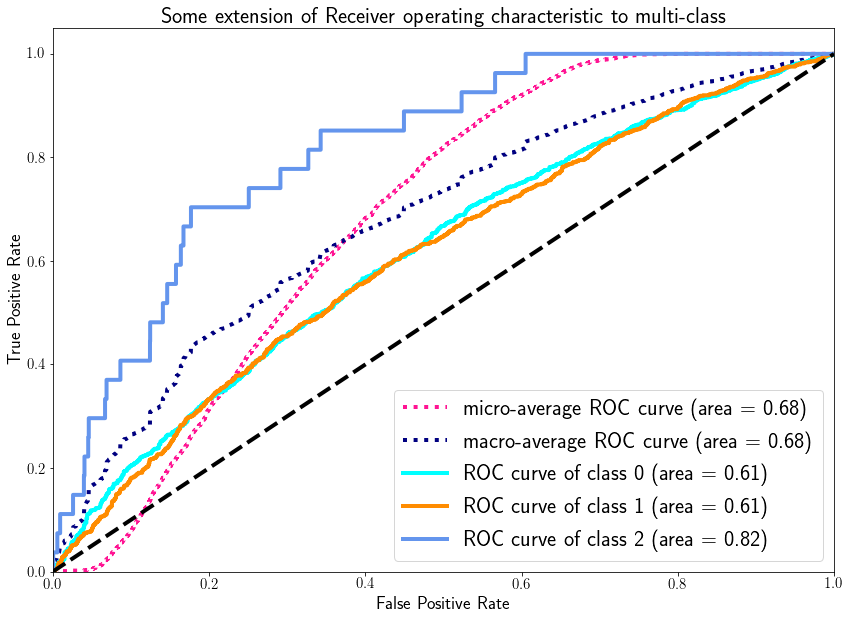

In [53]:
lw = 4
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(14,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Some extension of Receiver operating characteristic to multi-class', fontsize=22)
plt.legend(loc="lower right",fontsize=22)
plt.show()

##### precision-recall
[Desicion-recall](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py)

In [117]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’

In [118]:
clf = LogisticRegression(multi_class='multinomial',solver='newton-cg',
                         penalty='none', max_iter=200
                        ).fit(X_train, y_train)

/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [119]:
y_score_log = clf.decision_function(X_test)

In [129]:
y_score_log

array([[-0.21743565,  0.18285265,  0.03439929],
       [ 0.14572654,  0.26414231, -0.41051502],
       [ 0.4247765 ,  0.48270017, -0.90810932],
       ...,
       [ 0.65259919,  0.69268655, -1.34540874],
       [-0.56635806, -0.33487172,  0.90102513],
       [ 0.347593  ,  0.39296122, -0.74071095]])

In [120]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i],
                                                        y_score_log[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score_log[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(),
                                                                y_score_log.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_score_log,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.75


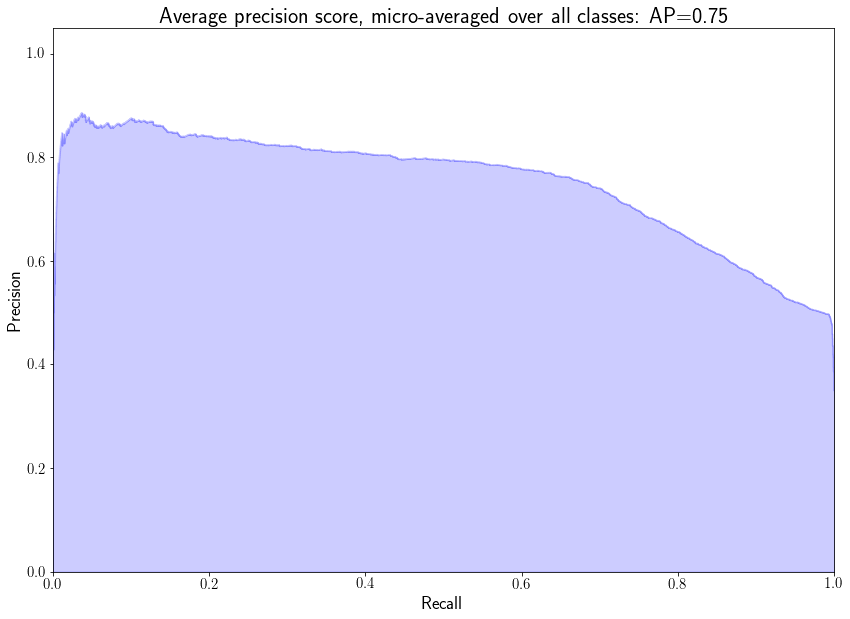

In [121]:
plt.figure(figsize=(14,10))
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel(r'Recall', fontsize=18)
plt.ylabel(r'Precision', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(r'Average precision score, micro-averaged over all classes: AP={0:0.2f}'.format(average_precision["micro"]),
          fontsize=22)
plt.show()

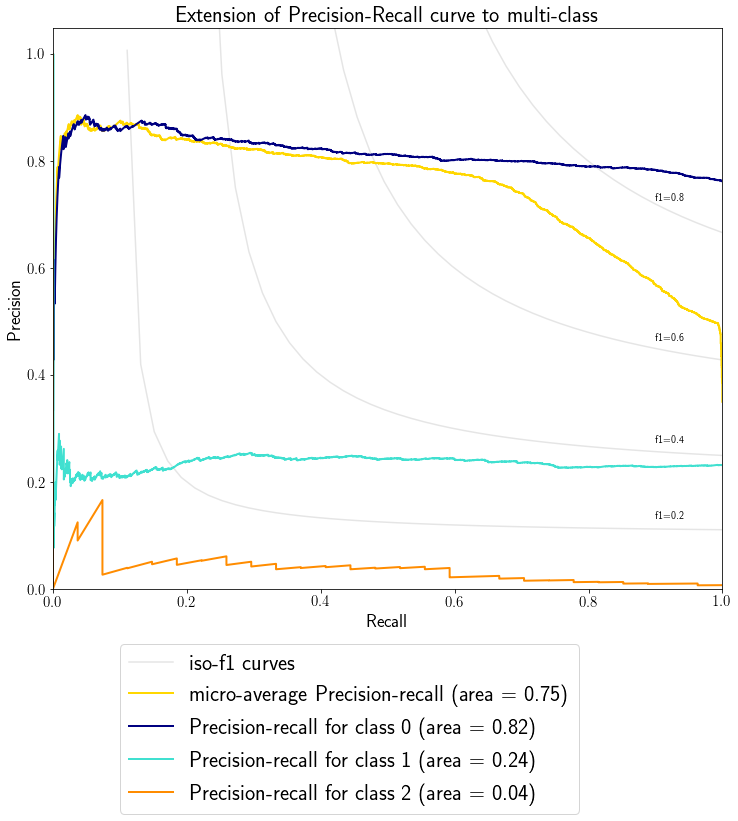

In [122]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(12,10))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Extension of Precision-Recall curve to multi-class',fontsize=22)
plt.legend(lines, labels, loc=(0.1, -0.4), prop=dict(size=22))


plt.show()

In [123]:
clf = LogisticRegression(multi_class='multinomial',solver='newton-cg',
                         penalty='none', max_iter=200,class_weight='balanced'
                        ).fit(X_train, y_train)

/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [124]:
y_score_log = clf.decision_function(X_test)

In [125]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i],
                                                        y_score_log[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score_log[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(),
                                                                y_score_log.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_score_log,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.47


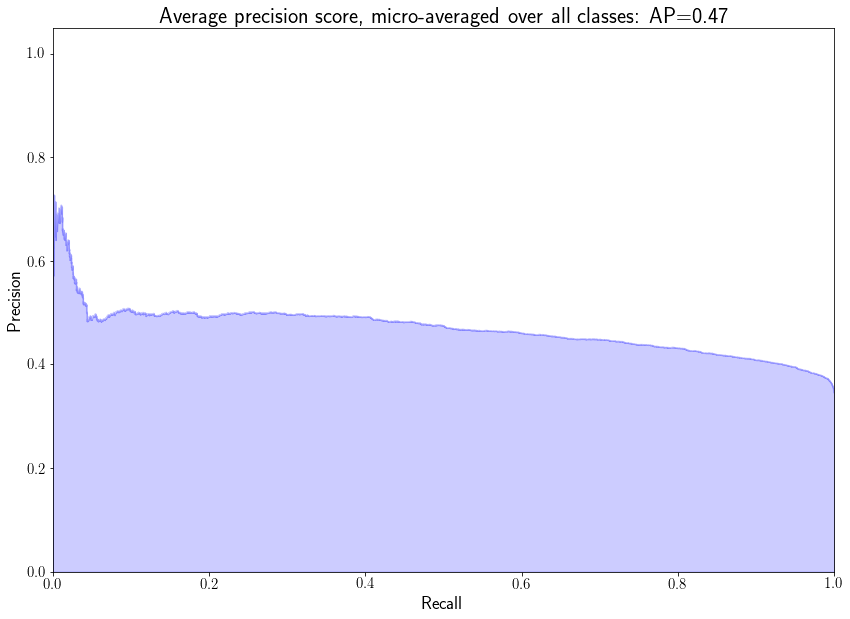

In [126]:
plt.figure(figsize=(14,10))
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel(r'Recall', fontsize=18)
plt.ylabel(r'Precision', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(r'Average precision score, micro-averaged over all classes: AP={0:0.2f}'.format(average_precision["micro"]),
          fontsize=22)
plt.show()

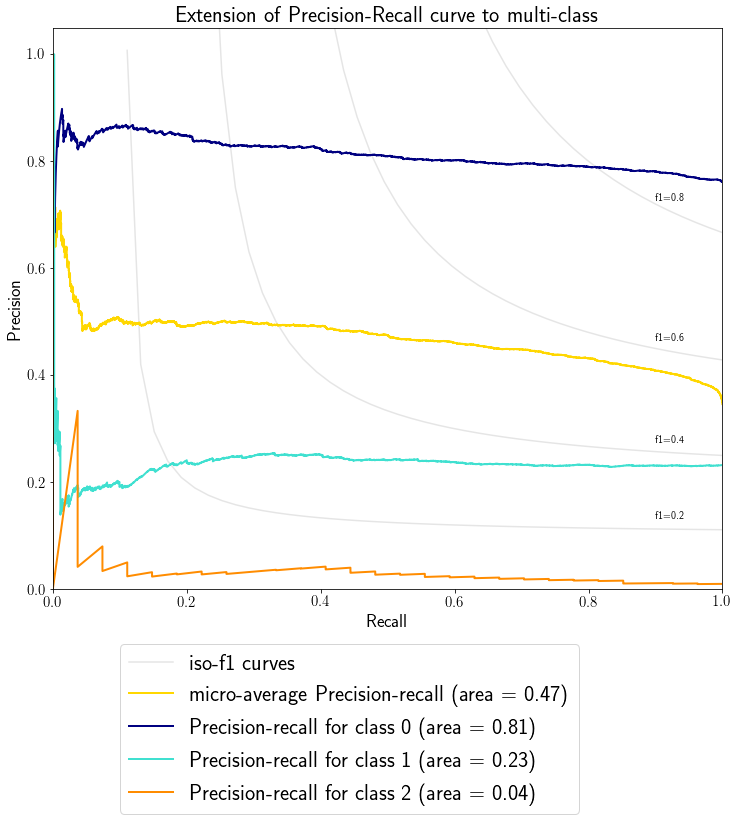

In [127]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(12,10))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Extension of Precision-Recall curve to multi-class',fontsize=22)
plt.legend(lines, labels, loc=(0.1, -0.4), prop=dict(size=22))


plt.show()